- [ ] 과거 주가 정보 수집
- [ ] 시계열 예측을 위한 데이터셋 형식 구성
- [ ] 회귀 모델을 사용해 미래 주가 예측
- [ ] LSTM 예측
- [ ] LSTM 성능 향상
- [ ] Tensorboard에 성능 시각화

> 함수들은 tools.py 안에 정리하기

In [1]:
# 균일한 노이즈가 추가된 코사인파
import numpy as np

def fetch_cosine_values(seq_len, frequency=0.1, noise=0.1):
    np.random.seed(101) # 실험 복제
    x = np.arange(0.0, seq_len, 1.0)
    return np.cos(2 * np.pi * frequency * x) + np.random.uniform(low=noise, high=noise, size=seq_len)

In [2]:
# 코사인파 출력
print(fetch_cosine_value(10, frequancy=0.1)) # 10개의 점, 0.1 크기의 잡음(∴주기 0.1)

[ 1.1         0.90901699  0.40901699 -0.20901699 -0.70901699 -0.9
 -0.70901699 -0.20901699  0.40901699  0.90901699]


In [3]:
# Quandl API 활용하기
curl "https://quandl.com/api/v3/datasets/WIKI/FB/data.csv"

SyntaxError: invalid syntax (2897179740.py, line 2)

In [7]:
# Quandl API로 종목 데이터 가져오기
import os
import pickle
import quandl

# string to datetime format
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')

# path에 pickle 저장
def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)

# load pickle, return object
def load_pickle(path):
    with open(path, 'rb') as fh:
      return pickle.load(fh)

def fetch_stock_price(symbol,
                      from_date,
                      to_date,
                      cache_path="./tmp/prices/"):
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    try:
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)
    except IOError:
        historic = quandl.get("WIKI/" + symbol,
                              start_date = date_obj_to_str(from_date),
                              end_date = date_obj_to_str(to_date))
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
    return prices

In [9]:
import datetime
print(fetch_stock_price("MSFT",
                        datetime.date(2021, 1, 1),
                        datetime.date(2022, 1, 31)))

[]


## 데이터셋 포맷 구성
- 특징 개수에 변화를 주는 대신 관측값의 크기를 고정시켜 미리 정의되지 않은 시계열 데이터의 추적 기간 설정하기

In [6]:
def format_dataset(values, temporal_features):
    feat_splits = [values[i:i + temporal_features] for i in range(len(values) - temporal_features)]
    feats = np.vstack(feat_splits)
    labels = np.array(values[temporal_features:])
    return feats, labels

- 시계열 데이터와 특징 크기가 주어지면, 시계열 데이터를 훑어 내려가는 슬라이딩 윈도우를 생성하고 특징과 레이블(반복할 때마다 슬라이딩 윈도우 끝에 따라오는 값)을 만든다. 마지막으로 모든 관측값은 레이블과 함께 세로로 연결된다.
- 결과는 정해진 개수의 열을 갖는 관측값과 레이블 벡터

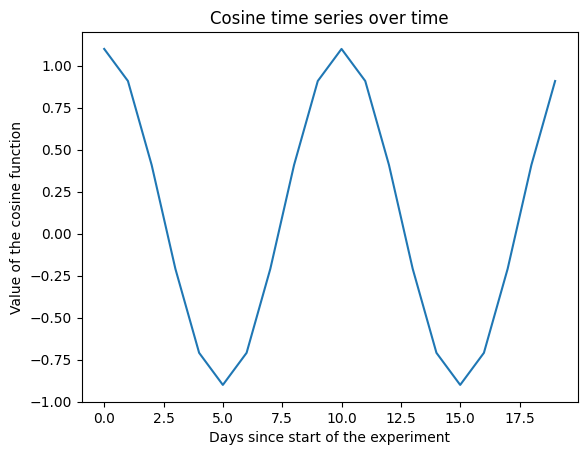

In [3]:
# draw cosine graph
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tools import fetch_cosine_values, fetch_stock_price, format_dataset
np.set_printoptions(precision=2)

cos_values = fetch_cosine_values(20, frequency=0.1)
seaborn.lineplot(x=range(len(cos_values)), y=cos_values)
plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the cosine function")
plt.title("Cosine time series over time")
plt.show()

위 코사인 그래프를 ML 알고리즘에서 받아들일 수 있는 형식으로 바꿔서 5개의 열을 갖는 관측 행렬을 만든다.

In [7]:
features_size = 5
minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, features_size)
print("minibatch_cos_X.shape=", minibatch_cos_X.shape)
print("minibatch_cos_y.shape=", minibatch_cos_y.shape)

minibatch_cos_X.shape= (15, 5)
minibatch_cos_y.shape= (15,)


0 관측: X=[ 1.1   0.91  0.41 -0.21 -0.71] y=-0.9
1 관측: X=[ 0.91  0.41 -0.21 -0.71 -0.9 ] y=-0.7090169943749475
2 관측: X=[ 0.41 -0.21 -0.71 -0.9  -0.71] y=-0.20901699437494756
3 관측: X=[-0.21 -0.71 -0.9  -0.71 -0.21] y=0.4090169943749472
4 관측: X=[-0.71 -0.9  -0.71 -0.21  0.41] y=0.9090169943749473


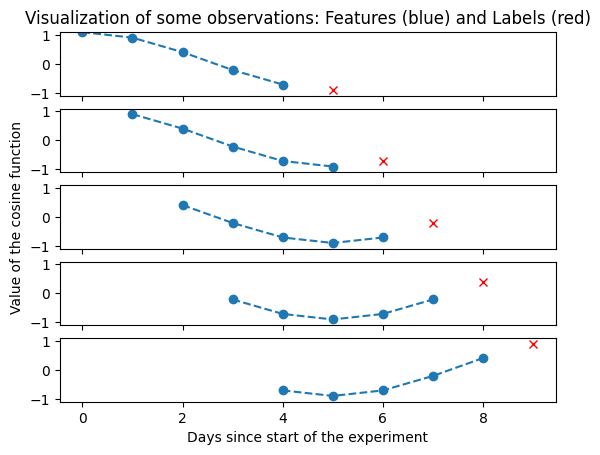

In [9]:
samples_to_plot = 5
f, axarr = plt.subplots(samples_to_plot, sharex=True)
for i in range(samples_to_plot):
    feats = minibatch_cos_X[i, :]
    label = minibatch_cos_y[i]
    print("{} 관측: X={} y={}".format(i, feats, label))
    plt.subplot(samples_to_plot, 1, i+1)
    axarr[i].plot(range(i, features_size + i), feats, '--o')
    axarr[i].plot([features_size + i], label, 'rx')
    axarr[i].set_ylim([-1.1, 1.1])
plt.xlabel("Days since start of the experiment")
axarr[2].set_ylabel("Value of the cosine function")
axarr[0].set_title("Visualization of some observations: Features (blue) and Labels (red)")
plt.show()

> 시계열이 관측 벡터가 되고 각 벡터의 크기는 5.

<function matplotlib.pyplot.show(close=None, block=None)>

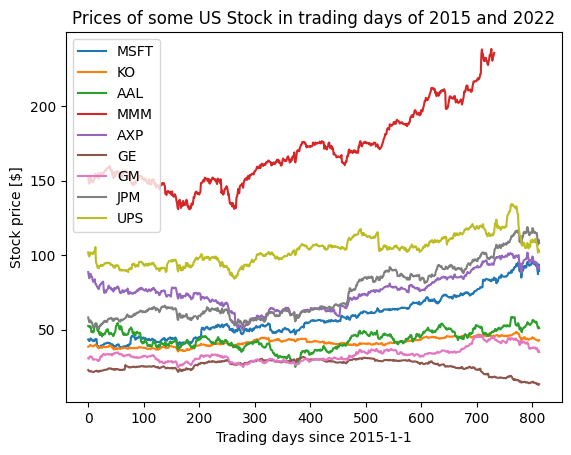

In [11]:
# 주가 그래프 확인
symbols = ["MSFT", "KO", "AAL", "MMM", "AXP", "GE", "GM", "JPM", "UPS"]
ax = plt.subplot(1, 1, 1)
for sym in symbols:
    prices = fetch_stock_price(sym, datetime.date(2015, 1, 1), datetime.date(2022, 12, 31))
    ax.plot(range(len(prices)), prices, label=sym)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel("Trading days since 2015-1-1")
plt.ylabel("Stock price [$]")
plt.title("Prices of some US Stock in trading days of 2015 and 2022")
plt.show

# 회귀 모델을 이용한 미래 주가 예측
> 문제를 회귀 문제로 다루게 되면 알고리즘은 각 특징이 독립적이라고 간주해야 한다. 그러나 여기서 시계열 데이터는 슬라이딩 윈도우로 서로 상관되어 있다. 어쨋든 각 특징이 독립적이라고 가정하고 회귀모델을 사용한 예측을 실행해 본 후, 시간적 상관관계를 활용해 성능을 향상시켜본다.
- MSE, MAE 출력
- 성능확인(훈련, 테스트, 예측)
- 결과 비교

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import tensorflow as tf
from evaluate_ts import evaluate_ts
from tools import fetch_cosine_values, format_dataset, fetch_stock_price

tf.config.run_functions_eagerly(True)
tf.random.set_seed(101)

symbol = "MSFT"
feat_dimension = 20
train_size = 252
test_size = 252 - feat_dimension

# 텐서플로우 매개변수 정의
learning_rate = 0.5
optimizer = tf.keras.optimizers.Adam
n_epochs = 20000

# 주가를 가져와 훈련 데이터와 테스트 데이터를 분할
stock_values = fetch_stock_price(symbol, datetime.date(2017, 1, 1), datetime.date(2018, 12, 31))
minibatch_cos_X, minibatch_cos_y = format_dataset(stock_values, feat_dimension)
train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

# Define the regression model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(feat_dimension,)))

# Define the loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Create an optimizer
optimizer = optimizer(learning_rate)

# Compile the model
model.compile(optimizer="adam", loss=loss_fn)

# Perform training
mse_values = []
mae_values = []
for epoch in range(n_epochs):
    model.fit(train_X, train_y, batch_size=train_size, verbose=0)
    train_loss = model.evaluate(train_X, train_y, verbose=0)
    test_loss = model.evaluate(test_X, test_y, verbose=0)
    y_pred = model.predict(test_X)
    mse = np.mean((y_pred - test_y) ** 2)
    mae = np.mean(np.abs(y_pred - test_y))
    mse_values.append(mse)
    mae_values.append(mae)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f} - MSE: {mse:.4f} - MAE: {mae:.4f}")

# Evaluate on test dataset
test_loss = model.evaluate(test_X, test_y)
y_pred = model.predict(test_X)

# Evaluate the results
evaluate_ts(test_X, test_y, y_pred)

# Plot the predicted and true values
plt.plot(range(len(cos_values)), cos_values, 'b')
plt.plot(range(len(cos_values) - test_size, len(cos_values)), y_pred, 'r--')
plt.xlabel("Days")
plt.ylabel("Predicted and true values")
plt.title("Predicted (Red) VS Real (Blue)")
plt.show()

D:\works\time-series-da\venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 0s 2ms/step
Epoch 1/20000 - Train Loss: 4018.3635 - Test Loss: 5951.1675 - MSE: 5951.1670 - MAE: 76.8886
2/2 [==============================] - 0s 971us/step
Epoch 2/20000 - Train Loss: 3836.3154 - Test Loss: 5671.4746 - MSE: 5671.4746 - MAE: 75.0478
2/2 [==============================] - 0s 2ms/step
Epoch 3/20000 - Train Loss: 3658.7034 - Test Loss: 5398.8599 - MSE: 5398.8599 - MAE: 73.2090
2/2 [==============================] - 0s 2ms/step
Epoch 4/20000 - Train Loss: 3485.5984 - Test Loss: 5133.4282 - MSE: 5133.4287 - MAE: 71.3731
2/2 [==============================] - 0s 972us/step
Epoch 5/20000 - Train Loss: 3317.0596 - Test Loss: 4875.2695 - MSE: 4875.2690 - MAE: 69.5411
2/2 [==============================] - 0s 997us/step
Epoch 6/20000 - Train Loss: 3153.1433 - Test Loss: 4624.4678 - MSE: 4624.4678 - MAE: 67.7138
2/2 [==============================] - 0s 2ms/step
Epoch 7/20000 - Train Loss: 2993.8965 - Test Loss: 4381.0938 - MSE: 4381.0942 -

이제, 위와 동일한 모델을 적용하여 주가에 적용해본다.